# Testing the Challenge

This notebook is used to apply the model to the challenge. This is using preformatted data that includes the features used for model training.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgbm

from matplotlib import pyplot

In [2]:
'''
Load the data
'''
data = pd.read_sas('data/who_rated_what_ans_wvars.sas7bdat')
answer_data = pd.read_csv('answer_data.csv')

In [3]:
'''
Set variable data to to match the correct rating value
'''
data.loc[(answer_data["Rating"] == 0),"Rated"] = 0

data.head()

,User_ID,Movie_ID,Year,Rated,Ratings_for_Movie,Ratings_for_Movie_2005,Netflix_Release_Year,Movie_Rating_Time,Movie_Ratings_per_Day,Release_Year,AVG_Rating_for_Movie,Ratings_from_User,Ratings_from_User_2005,AVG_Rating_from_User,User_Rating_Time,User_Ratings_per_Day,User_Entry_Year
0,6.0,16983.0,2006.0,0.0,546.0,222.0,2000.0,5.965777,0.250574,1987.0,3.474359,626.0,310.0,3.418530,1.738535,0.985827,2004.0
1,10.0,15957.0,2006.0,0.0,2122.0,1198.0,2003.0,2.872005,2.022879,1998.0,3.905278,260.0,91.0,3.392308,2.847365,0.250000,2002.0
2,10.0,14584.0,2006.0,1.0,37492.0,18285.0,1999.0,6.004107,17.096215,1999.0,3.819455,260.0,91.0,3.392308,2.847365,0.250000,2002.0
3,10.0,11888.0,2006.0,0.0,51611.0,28415.0,1999.0,6.056126,23.332278,1993.0,3.790239,260.0,91.0,3.392308,2.847365,0.250000,2002.0
4,131.0,17405.0,2006.0,0.0,58563.0,58562.0,2004.0,1.002053,160.008197,2005.0,3.523761,131.0,131.0,3.175573,0.717317,0.500000,2005.0


In [4]:
'''
Preprocess the data (separate features from labels)
'''
X = data.drop(['User_ID', 'Movie_ID', 'Rated'], axis=1)
Y = data['Rated'].values

In [5]:
'''
Print available models
'''
import os

print(next(os.walk('models'))[2])

['m50M_500.txt', 'm50M_10000.txt', 'm25M_400.txt', 'm50M_250.txt', 'model.txt', 'm25M_250.txt', 'm1000_002.txt', 'm1000.txt', 'm50M_1K.txt', 'm1.txt']


In [6]:
'''
Load the model
'''
model = lgbm.Booster(model_file = 'models/m50M_1K.txt')

In [7]:
'''
Create predictions
'''
predictions = model.predict(X)

In [8]:
'''
Evaluate
'''
from sklearn.metrics import accuracy_score

print("Accuracy: {}".format(accuracy_score(Y, predictions > 0.5)))

Accuracy: 0.81863


In [9]:
'''
Output classification report from sklearn
'''
from sklearn.metrics import classification_report

print(classification_report(Y, predictions > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90     92196
         1.0       0.12      0.20      0.15      7804

    accuracy                           0.82    100000
   macro avg       0.52      0.54      0.52    100000
weighted avg       0.86      0.82      0.84    100000



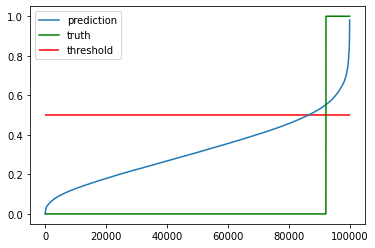

In [10]:
'''
Plot the sorted label output and the sorted ground truth output

This only shows the relative uncertainty of the classification. 
A lot of the predictions are close to the 0.5 threshold.
'''

pyplot.plot(np.sort(predictions), label = 'prediction')
pyplot.plot(np.sort(data['Rated'].values), color='green', label='truth')
pyplot.hlines(xmin=0, xmax=len(predictions), y=0.5, color='red', label='threshold')
pyplot.legend()
pyplot.show()

There are more predicted positives than the number that exist.

The accuracy is very good, but the recall and precision for the positives is poor, which is probably more important. Just guessing negative would result in an accuracy of ~0.922,  but recall and precision of 0.0.

If the goal was "Who didn't rate what?", the model would perform well.

In [11]:
'''
Compare the RMSE of the model and only guessing 0's
'''

print("LightGBM RSME:\t{}".format(np.sqrt(np.mean(np.power(Y-(predictions > 0.5), 2)))))
print("All zeros RSME:\t{}".format(np.sqrt(np.mean(np.power(Y-0, 2)))))

LightGBM RSME:	0.42587556868174536
All zeros RSME:	0.2793564031841762


The model underperforms guessing 0's for RMSE. Probable fixes would be to add more features and train more data for longer.

In [14]:
'''

'''

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(Y, predictions > 0.5)

pd.DataFrame(matrix)

,0,1
0,80274,11922
1,6215,1589


The model too often guesses "1" for ground truth "0".

The missing data is more features. The model performance for adding more training steps and data is almost identical.